# Stellar color (B-I)

In [1]:
import pynbody
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pynbody.plot.stars import convert_to_mag_arcsec2
from pynbody.derived import lum_den_template
from luminosity import color_plot

snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"

s = pynbody.load(snap)

pynbody.analysis.halo.center(s.s, vel=True);

mags = pynbody.analysis.luminosity.calc_mags(s.s)
mags.shape, mags.units

((140168,), NoUnit())

In [2]:
s.properties['boxsize'] = pynbody.units.Unit("1 Gpc")

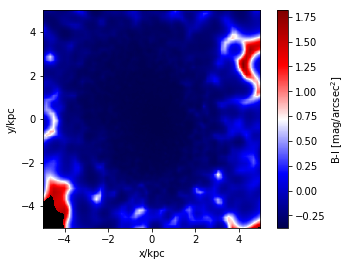

In [3]:
color_plot(s, width=10, bands=('b', 'i'));

# Test step by step

In [4]:
width = 6
resolution = 500

luminosity density is in unit: 10^(-0.4) mag per unit volume, and it is defined as:

```
val = (10 ** (-0.4 * s[band + "_mag"])) * s['rho'] / s['mass']
val.units = s['rho'].units/s['mass'].units
return val
```

In [5]:
sphere = pynbody.filt.Sphere('5 kpc')
sphere

Sphere('5.00e+00 kpc', array([0, 0, 0]))

In [6]:
# surface_brightness(subsnap, width=width, resolution=resolution);

In [7]:
s

<SimSnap "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036" len=3999940>

In [8]:
subsnap = s[sphere]
subsnap

<SimSnap "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036:sphere" len=250221>

In [9]:
subsnap.s

<SimSnap "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036:sphere::star" len=120840>

In [10]:
pynbody.analysis.angmom.sideon(subsnap.s)

In [11]:
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
L

array([-6.0995713e-05,  4.4367370e-01, -8.0503349e-05], dtype=float32)

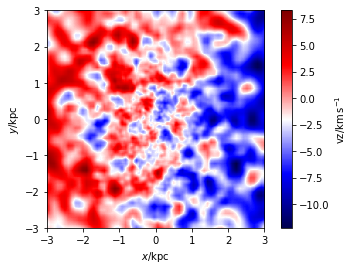

In [12]:
v_los_sim = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, cmap='seismic',
                                   width=width, resolution=resolution, log=False)

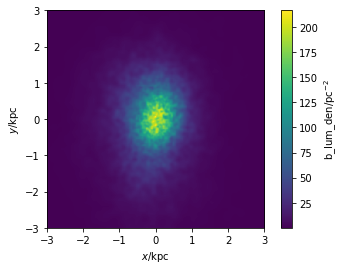

In [13]:
band0_pc2 = pynbody.plot.sph.image(subsnap.s, qty='b_lum_den', units='pc^-2', width=width, log=False, resolution=resolution)

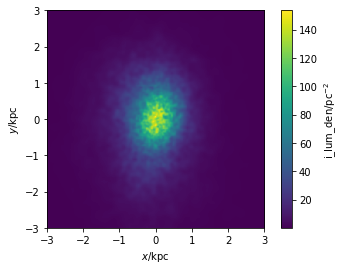

In [15]:
band1_pc2 = pynbody.plot.sph.image(subsnap.s, qty='i_lum_den', units='pc^-2', width=width, log=False, resolution=resolution)

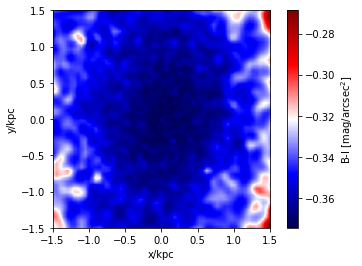

In [16]:
color_plot(subsnap, width=3, bands=('b', 'i'), mag_filter=None);

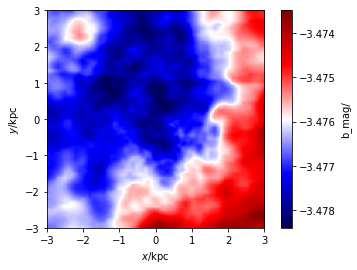

In [11]:
b = pynbody.plot.sph.image(s.s, qty='b_mag', av_z=True, width=width, log=False, resolution=resolution, cmap='seismic')

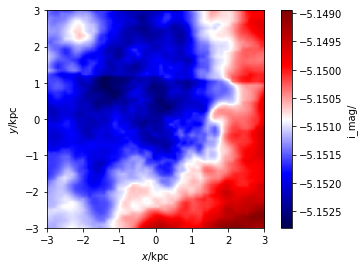

In [12]:
i = pynbody.plot.sph.image(s.s, qty='i_mag', av_z=True, width=width, log=False, resolution=resolution, cmap='seismic')

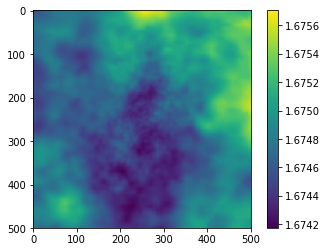

In [13]:
plt.imshow(b-i)
plt.colorbar()

In [14]:
# s.s['b-i_lum_den'] = lum_den_template('b-i', s.s)
# s.s['b-i_lum_den']

In [15]:
# bmi_pc2 = pynbody.plot.sph.image(s.s, qty='b-i_lum_den', units='pc^-2', width=width, log=False, resolution=resolution)

In [16]:
bmi_pc2

NameError: name 'bmi_pc2' is not defined

In [17]:
def my_convert_to_mag_arcsec2(image):
    assert image.units=="pc^-2"
    pc2_to_sqarcsec = 2.3504430539466191e-09
    img_mag_arcsec2 = -2.5 * np.log10(image * pc2_to_sqarcsec)
    img_mag_arcsec2.units = pynbody.units.arcsec**-2
    return img_mag_arcsec2

In [18]:
pynbody.units.pc/pynbody.units.arcsec

Unit("pc arcsec**-1")

In [19]:
# s.s['bmi_mag_arcsec2'] = my_convert_to_mag_arcsec2(bmi_pc2)
bmi_mag_arcsec2 = my_convert_to_mag_arcsec2(bmi_pc2)
bmi_mag_arcsec2

NameError: name 'bmi_pc2' is not defined

In [20]:
bmi_mag_arcsec2[bmi_mag_arcsec2 > 29] = np.nan
fig, ax = plt.subplots(1)
cmap = matplotlib.cm.seismic
cmap.set_bad('black')
img = ax.imshow(bmi_mag_arcsec2, cmap=cmap, extent=(-width/2, width/2, -width/2, width/2))
cbar = fig.colorbar(img);

cbar.set_label('B-I [mag/arcsec$^2$]');

NameError: name 'bmi_mag_arcsec2' is not defined

# Try with a real simulation

In [21]:
import simulation

In [22]:
SIMPATH = '/media/michele/My Book/Michele/MySimulations/MovingBox/hi_osc/mb.71002_p500_a800_r600/out'

In [25]:
sim = simulation.Simulation(SIMPATH)

loading simulation: /media/michele/My Book/Michele/MySimulations/MovingBox/hi_osc/mb.71002_p500_a800_r600/out
Found parameter file
Found compiler file
Found 563 snapshots
Loading cosmological parameters
Found trace file


In [27]:
import ipywidgets

snap_slider = ipywidgets.IntSlider(min=0,max=len(sim)-1,step=1,value=0, continuous_update=False, description='Snap:')
# fig, ax = plt.subplots()

def k(i):
    snap = sim[i]
    print(len(snap.s))
    color_plot(snap, width=20, title='{:.2f}'.format(snap.header.time), center=True, mag_filter=32)

w = ipywidgets.interactive(k, i=snap_slider)
w

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=562), Output()), _d…